In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()  # monkey patch pandas to use tqdm; keep the above import order


In [2]:
import sidechainnet as scn
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import prody as pr
sns.set_style('darkgrid')
# %cd /net/pulsar/home/koes/jok120/openfold
%matplotlib inline
# increase the default matplotlib plot size
plt.rcParams['figure.figsize'] = (6.0, 8.0)

# Protein Minimization Summary

In [3]:
# Path to reminimization output files:
outfiles_dir = "/net/pulsar/home/koes/jok120/repos/sidechainnet/sidechainnet/research/cluster/230307"
summary_file = "rmsd_ca_230317.csv"

In [4]:
!echo "There are" $(ls -1 /net/pulsar/home/koes/jok120/scnmin230306/min/*.pkl | wc -l) "minimized proteins."
!echo "There are" $(ls -1 /net/pulsar/home/koes/jok120/scnmin230306/failed/* | wc -l) "failed proteins."
!echo ""
!echo "protein_name,key,rmsd_ca,duration" > $summary_file
!grep -hr RMSD_CA $outfiles_dir/ >> $summary_file

There are 20332 minimized proteins.
There are 13633 failed proteins.



In [5]:
df = pd.read_csv(summary_file)
df.sort_values(by='rmsd_ca', ascending=True).head()

,protein_name,key,rmsd_ca,duration
12391,1TZS_3_X,RMSD_CA,0.006024,7.288131
8863,1O6O_2_D,RMSD_CA,0.013468,8.264843
18900,2E4H_2_B,RMSD_CA,0.020500,9.090670
10052,1Q1S_1_A,RMSD_CA,0.022180,6.973112
12390,1TZS_2_P,RMSD_CA,0.022475,7.614296


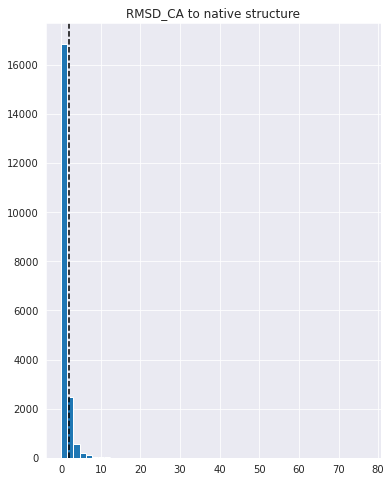

Fraction of structures with RMSD_CA < 2: 0.8892823766661748
Fraction of structures with RMSD_CA < 1: 0.6876198908071418

Number of structures with RMSD_CA < 2: 18080
Number of structures with RMSD_CA > 2: 2251

Number of structures with RMSD_CA < 3: 19293
Number of structures with RMSD_CA > 3: 1038

Number of structures with RMSD_CA < 4: 19761
Number of structures with RMSD_CA > 4: 570

Number of structures with RMSD_CA < 5: 19957
Number of structures with RMSD_CA > 5: 374



count    20331.000000
mean         1.076167
std          1.474956
min          0.006024
25%          0.446287
50%          0.665932
75%          1.181113
max         76.839791
Name: rmsd_ca, dtype: float64

In [6]:
df.hist(column="rmsd_ca", bins=50)
plt.title("RMSD_CA to native structure")
plt.axvline(2, color="k", linestyle="dashed");
plt.show()

print("Fraction of structures with RMSD_CA < 2:", len(df[df['rmsd_ca'] < 2]) / len(df))
print("Fraction of structures with RMSD_CA < 1:", len(df[df['rmsd_ca'] < 1]) / len(df))
print("")
print("Number of structures with RMSD_CA < 2:", len(df[df['rmsd_ca'] < 2]))
print("Number of structures with RMSD_CA > 2:", len(df[df['rmsd_ca'] > 2]))
print("")
print("Number of structures with RMSD_CA < 3:", len(df[df['rmsd_ca'] < 3]))
print("Number of structures with RMSD_CA > 3:", len(df[df['rmsd_ca'] > 3]))
print("")
print("Number of structures with RMSD_CA < 4:", len(df[df['rmsd_ca'] < 4]))
print("Number of structures with RMSD_CA > 4:", len(df[df['rmsd_ca'] > 4]))
print("")
print("Number of structures with RMSD_CA < 5:", len(df[df['rmsd_ca'] < 5]))
print("Number of structures with RMSD_CA > 5:", len(df[df['rmsd_ca'] > 5]))
print("")
df['rmsd_ca'].describe()

# Current training set

In [7]:
currently_training_proteins_structs = glob("/net/pulsar/home/koes/jok120/openfold/data/train_structs/random10k/*cif")
currently_training_proteins_structs = [p.split("/")[-1].split(".")[0] for p in currently_training_proteins_structs]
len(currently_training_proteins_structs), currently_training_proteins_structs[:5]

(10000, ['1yrd', '1bqe', '6en7', '5fx6', '1l8s'])

In [8]:
currently_training_proteins_alns = glob("/net/pulsar/home/koes/jok120/openfold/data/alignments/random10k/*")
currently_training_proteins_alns = [p.split("/")[-1].split(".")[0] for p in currently_training_proteins_alns]
len(currently_training_proteins_alns), currently_training_proteins_alns[:5]

(10000, ['5cc0_A', '5mov_A', '3ukg_A', '1myi_A', '7mu2_A'])

# Let's try to get a list of all the good scnmin proteins.
They should have:
* low rmsd (< 5)
* not be ASTRAL (since this likely won't work with alignments very well)
* have the same protein sequence as the one from the alignment I already have

### Low RMSD

In [9]:
RMSD_THRESHOLD = 5
df

,protein_name,key,rmsd_ca,duration
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634
...,...,...,...,...
20326,2GJF_1_A,RMSD_CA,0.453337,89.160513
20327,2GJH_1_A,RMSD_CA,0.715245,119.571822
20328,2GJJ_d2gjja1,RMSD_CA,0.272346,263.892892
20329,2GJL_1_A,RMSD_CA,0.522321,2733.075953


In [10]:
df_lowrmsd = df[df['rmsd_ca'] < RMSD_THRESHOLD]
df_lowrmsd

,protein_name,key,rmsd_ca,duration
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634
...,...,...,...,...
20326,2GJF_1_A,RMSD_CA,0.453337,89.160513
20327,2GJH_1_A,RMSD_CA,0.715245,119.571822
20328,2GJJ_d2gjja1,RMSD_CA,0.272346,263.892892
20329,2GJL_1_A,RMSD_CA,0.522321,2733.075953


### Removing ASTRAL & Improve Names

In [11]:
# Remove the rows in the dataframe that contain only one _ in the protein_name column
df_lowrmsd_nonastral = df_lowrmsd[df_lowrmsd['protein_name'].str.count("_")==2]
df_lowrmsd_nonastral

,protein_name,key,rmsd_ca,duration
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634
...,...,...,...,...
20320,2GJ1_1_A,RMSD_CA,0.672079,222.282119
20325,2GJD_1_A,RMSD_CA,0.322955,1325.744157
20326,2GJF_1_A,RMSD_CA,0.453337,89.160513
20327,2GJH_1_A,RMSD_CA,0.715245,119.571822


In [12]:
# Create a new column in the dataframe that contains the protein_name without the _1 or _2
df_lowrmsd_nonastral['protein_name_std'] = df_lowrmsd_nonastral['protein_name'].str.split("_").str[0].str.lower() + "_" + df_lowrmsd_nonastral['protein_name'].str.split("_").str[2]
# If the protein_name_std starts with a number and a #, remove the start of the name
df_lowrmsd_nonastral['protein_name_std'] = df_lowrmsd_nonastral['protein_name_std'].str.replace("^[0-9]+#", "")

/tmp/ipykernel_585420/924830777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['protein_name_std'] = df_lowrmsd_nonastral['protein_name'].str.split("_").str[0].str.lower() + "_" + df_lowrmsd_nonastral['protein_name'].str.split("_").str[2]
/tmp/ipykernel_585420/924830777.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_lowrmsd_nonastral['protein_name_std'] = df_lowrmsd_nonastral['protein_name_std'].str.replace("^[0-9]+#", "")
/tmp/ipykernel_585420/924830777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [13]:
df_lowrmsd_nonastral

,protein_name,key,rmsd_ca,duration,protein_name_std
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A
...,...,...,...,...,...
20320,2GJ1_1_A,RMSD_CA,0.672079,222.282119,2gj1_A
20325,2GJD_1_A,RMSD_CA,0.322955,1325.744157,2gjd_A
20326,2GJF_1_A,RMSD_CA,0.453337,89.160513,2gjf_A
20327,2GJH_1_A,RMSD_CA,0.715245,119.571822,2gjh_A


### Looking more closely at sequences
Can we find proteins of mine that exactly match the RODA MSAs I already have? Those would
be the easiest to work with.

In [14]:
def get_sequence(pdbfile):
    """Returns the sequence of the protein in the pdbfile."""
    pdb = pr.parsePDB(pdbfile)
    return pdb.ca.getSequence()

get_sequence("/net/pulsar/home/koes/jok120/scnmin230306/min/2FD3_1_A.pdb")

'SDKIIHLTDDSFDTDVLKADGAILVDFWAEWCGHCKMIAPILDEIADEYQGKLTVAKLNIDQNPGTAPKYGIRGIPTLLLFKNGEVAATKVGALSKGQLKEFLDANLA'

In [15]:
# Add sequence column to dataframe using get_sequence function
df_lowrmsd_nonastral['sequence'] = df_lowrmsd_nonastral['protein_name'].progress_apply(lambda x: get_sequence("/net/pulsar/home/koes/jok120/scnmin230306/min/" + x + ".pdb"))

  0%|          | 0/12733 [00:00<?, ?it/s]

/tmp/ipykernel_585420/4226272153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['sequence'] = df_lowrmsd_nonastral['protein_name'].progress_apply(lambda x: get_sequence("/net/pulsar/home/koes/jok120/scnmin230306/min/" + x + ".pdb"))


In [16]:
df_lowrmsd_nonastral

,protein_name,key,rmsd_ca,duration,protein_name_std,sequence
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A,HMTFCLETYLQQSGEYEIHMKRAGFRECAAMIEKKARRVVHIKPGE...
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...
...,...,...,...,...,...,...
20320,2GJ1_1_A,RMSD_CA,0.672079,222.282119,2gj1_A,VKCDENSPYRTITGDCNNRRSPALGAANRALARWLPAEYEDGLALP...
20325,2GJD_1_A,RMSD_CA,0.322955,1325.744157,2gjd_A,SLCLQRLQEERKKWRKDHPFGFYAKPVKKADGSMDLQKWEAGIPGK...
20326,2GJF_1_A,RMSD_CA,0.453337,89.160513,2gjf_A,GSKTIFVIVPTNEEQVAFLEALAKQDELNFDWQNPPTEPGQPVVIL...
20327,2GJH_1_A,RMSD_CA,0.715245,119.571822,2gjh_A,ERVRISITARTKKEAEKFAAILIKVFAELGYNDINVTWDGDTVTVE...


In [17]:
# Let's add a column representing the query sequence
def get_query_sequence(protein_name):
    try:
        alignment_file = glob(f"/net/pulsar/home/koes/jok120/openfold/data/alignments/roda_flattened/alignments/{protein_name}/*.a3m")[0]
    except IndexError:
        return None
    # Read the second line of the alignment file, which contains the query sequence
    with open(alignment_file, "r") as f:
        query_sequence = f.readlines()[1].strip()
    return query_sequence

df_lowrmsd_nonastral['query_sequence'] = df_lowrmsd_nonastral['protein_name_std'].progress_apply(lambda x: get_query_sequence(x))

  0%|          | 0/12733 [00:00<?, ?it/s]

/tmp/ipykernel_585420/3002578744.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['query_sequence'] = df_lowrmsd_nonastral['protein_name_std'].progress_apply(lambda x: get_query_sequence(x))


In [18]:
# Lets denote if we even have an existing cif file
def cif_exists(protein_name):
    """Returns True iff the cif file exists."""
    return os.path.exists(f"/net/pulsar/home/koes/jok120/openfold/data/train_structs/roda_pdbs_snapshotted_flattened_do_not_overwrite/{protein_name.split('_')[0]}.cif")

df_lowrmsd_nonastral['cif_exists'] = df_lowrmsd_nonastral['protein_name_std'].progress_apply(lambda x: cif_exists(x))

  0%|          | 0/12733 [00:00<?, ?it/s]

/tmp/ipykernel_585420/1604743634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['cif_exists'] = df_lowrmsd_nonastral['protein_name_std'].progress_apply(lambda x: cif_exists(x))


In [19]:
POOR_ALIGNMENT_FILE = open("seqs_didnot_match.txt", "w")    
def query_and_sequence_match(protein_name, query_sequence, protein_sequence):
    """Returns True iff the query sequence matches the sequence."""
    if query_sequence != protein_sequence:
        POOR_ALIGNMENT_FILE.write(f"{protein_name},{protein_sequence},{query_sequence}\n")
        return False
    else:
        return True

In [20]:
# Add a column that denotes if the string fields query_sequence and sequence are equal
df_lowrmsd_nonastral['sequence_matches_query'] = df_lowrmsd_nonastral.apply(lambda x: query_and_sequence_match(x['protein_name_std'], x['query_sequence'], x['sequence']), axis=1)
df_lowrmsd_nonastral


/tmp/ipykernel_585420/3952515568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['sequence_matches_query'] = df_lowrmsd_nonastral.apply(lambda x: query_and_sequence_match(x['protein_name_std'], x['query_sequence'], x['sequence']), axis=1)


,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,True,True
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,True,True
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A,HMTFCLETYLQQSGEYEIHMKRAGFRECAAMIEKKARRVVHIKPGE...,MGSSHHHHHHSSGLVPRGSHMTFCLETYLQQSGEYEIHMKRAGFRE...,True,False
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS,GPHMSVQIPVVEVDELPEGYDRS,True,True
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,True,True
...,...,...,...,...,...,...,...,...,...
20320,2GJ1_1_A,RMSD_CA,0.672079,222.282119,2gj1_A,VKCDENSPYRTITGDCNNRRSPALGAANRALARWLPAEYEDGLALP...,None,False,False
20325,2GJD_1_A,RMSD_CA,0.322955,1325.744157,2gjd_A,SLCLQRLQEERKKWRKDHPFGFYAKPVKKADGSMDLQKWEAGIPGK...,None,True,False
20326,2GJF_1_A,RMSD_CA,0.453337,89.160513,2gjf_A,GSKTIFVIVPTNEEQVAFLEALAKQDELNFDWQNPPTEPGQPVVIL...,HHHHHHGSKTIFVIVPTNEEQVAFLEALAKQDELNFDWQNPPTEPG...,True,False
20327,2GJH_1_A,RMSD_CA,0.715245,119.571822,2gjh_A,ERVRISITARTKKEAEKFAAILIKVFAELGYNDINVTWDGDTVTVE...,MERVRISITARTKKEAEKFAAILIKVFAELGYNDINVTWDGDTVTV...,True,False


In [21]:
df_lowrmsd_nonastral[df_lowrmsd_nonastral['sequence_matches_query'] == True]

,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,True,True
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,True,True
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS,GPHMSVQIPVVEVDELPEGYDRS,True,True
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,True,True
6,10#2KW1_1_A,RMSD_CA,0.232314,120.852532,2kw1_A,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,True,True
...,...,...,...,...,...,...,...,...,...
20292,2GGT_1_A,RMSD_CA,0.648192,1521.041160,2ggt_A,LLGGPFSLTTHTGERKTDKDYLGQWLLIYFGFTHCPDVCPEELEKM...,LLGGPFSLTTHTGERKTDKDYLGQWLLIYFGFTHCPDVCPEELEKM...,True,True
20298,2GH4_1_A,RMSD_CA,0.517604,11790.038120,2gh4_A,KSPLTYAEALANTIMNTYTVEELPPANRWHYHQGVFLCGVLRLWEA...,KSPLTYAEALANTIMNTYTVEELPPANRWHYHQGVFLCGVLRLWEA...,True,True
20301,2GHF_1_A,RMSD_CA,2.445763,280.117103,2ghf_A,MAHHHHHHNQQNKKVEGGYECKYCTFQTPDLNMFTFHVDSEHPNVV...,MAHHHHHHNQQNKKVEGGYECKYCTFQTPDLNMFTFHVDSEHPNVV...,True,True
20316,2GIM_1_A,RMSD_CA,0.213682,401.875954,2gim_A,METYTVKLGSDKGLLVFEPAKLTIKPGDTVEFLNNKVPPHNVVFDA...,METYTVKLGSDKGLLVFEPAKLTIKPGDTVEFLNNKVPPHNVVFDA...,True,True


In [22]:
# Show rows where the alignment exists and matches and the cif file exists
df_lowrmsd_nonastral[(df_lowrmsd_nonastral['sequence_matches_query'] == True) & (df_lowrmsd_nonastral['cif_exists'] == True)]

,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,True,True
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,True,True
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS,GPHMSVQIPVVEVDELPEGYDRS,True,True
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,True,True
6,10#2KW1_1_A,RMSD_CA,0.232314,120.852532,2kw1_A,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,True,True
...,...,...,...,...,...,...,...,...,...
20292,2GGT_1_A,RMSD_CA,0.648192,1521.041160,2ggt_A,LLGGPFSLTTHTGERKTDKDYLGQWLLIYFGFTHCPDVCPEELEKM...,LLGGPFSLTTHTGERKTDKDYLGQWLLIYFGFTHCPDVCPEELEKM...,True,True
20298,2GH4_1_A,RMSD_CA,0.517604,11790.038120,2gh4_A,KSPLTYAEALANTIMNTYTVEELPPANRWHYHQGVFLCGVLRLWEA...,KSPLTYAEALANTIMNTYTVEELPPANRWHYHQGVFLCGVLRLWEA...,True,True
20301,2GHF_1_A,RMSD_CA,2.445763,280.117103,2ghf_A,MAHHHHHHNQQNKKVEGGYECKYCTFQTPDLNMFTFHVDSEHPNVV...,MAHHHHHHNQQNKKVEGGYECKYCTFQTPDLNMFTFHVDSEHPNVV...,True,True
20316,2GIM_1_A,RMSD_CA,0.213682,401.875954,2gim_A,METYTVKLGSDKGLLVFEPAKLTIKPGDTVEFLNNKVPPHNVVFDA...,METYTVKLGSDKGLLVFEPAKLTIKPGDTVEFLNNKVPPHNVVFDA...,True,True


In [23]:
# Add a column that denotes if the sequence is a subset of the query sequence
def sequence_is_subsequence(query_sequence, protein_sequence):
    """Returns True iff the protein sequence is a subset of the query sequence."""
    if query_sequence is not None and protein_sequence in query_sequence:
        return True
    else:
        return False

df_lowrmsd_nonastral['sequence_is_subsequence'] = df_lowrmsd_nonastral.progress_apply(lambda x: sequence_is_subsequence(x['query_sequence'], x['sequence']), axis=1)
df_lowrmsd_nonastral[(df_lowrmsd_nonastral['sequence_is_subsequence'] == True) & (df_lowrmsd_nonastral['sequence_matches_query'] == False)]

  0%|          | 0/12733 [00:00<?, ?it/s]

/tmp/ipykernel_585420/3174430049.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['sequence_is_subsequence'] = df_lowrmsd_nonastral.progress_apply(lambda x: sequence_is_subsequence(x['query_sequence'], x['sequence']), axis=1)


,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query,sequence_is_subsequence
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A,HMTFCLETYLQQSGEYEIHMKRAGFRECAAMIEKKARRVVHIKPGE...,MGSSHHHHHHSSGLVPRGSHMTFCLETYLQQSGEYEIHMKRAGFRE...,True,False,True
5,10#3NO7_1_A,RMSD_CA,1.095250,81.944621,3no7_A,VKMTVTVGEERRARLRTAYTLTHLQEGHRTFSGFIAAALDAEVQRL...,GPEASARSEVKMTVTVGEERRARLRTAYTLTHLQEGHRTFSGFIAA...,True,False,True
7,10#2FK5_1_A,RMSD_CA,0.852786,1856.631196,2fk5_A,RARLYAAFRQVGEDLFAQGLISATAGNFSVRTKGGFLITKSGVQKA...,MRARLYAAFRQVGEDLFAQGLISATAGNFSVRTKGGFLITKSGVQK...,True,False,True
10,10#3ALR_1_A,RMSD_CA,0.329806,65.406627,3alr_A,FCSFCKHNGETEAVYTSHYLKNRDGDVMCPYLRQYKCPLCGATGAK...,GPLGSESPSGPIRSRDSPEQNTSPGGGKPKSSPAERKFCSFCKHNG...,True,False,True
11,10#4QTQ_1_A,RMSD_CA,0.394599,1130.503295,4qtq_A,KMPSTANAKLNEQGEISADIGGIAVSVHAQSCTEDSPGIMLCNRSP...,MQKDLKMPSTANAKLNEQGEISADIGGIAVSVHAQSCTEDSPGIML...,True,False,True
...,...,...,...,...,...,...,...,...,...,...
20313,2GIA_2_B,RMSD_CA,0.484649,830.006323,2gia_B,SLPKFEIHDVRDDPAEGTMTRVAVDGKLLLISQYPQLGPRKVDPND...,ASTFSGVQSLPKFEIHDVRDDPAEGTMTRVAVDGKLLLISQYPQLG...,True,False,True
20315,2GIL_1_A,RMSD_CA,0.581010,686.283973,2gil_A,FKLVFLGEQSVGKTSLITRFMYDSFDNTYQATIGIDFLSKTMYLED...,KFKLVFLGEQSVGKTSLITRFMYDSFDNTYQATIGIDFLSKTMYLE...,True,False,True
20326,2GJF_1_A,RMSD_CA,0.453337,89.160513,2gjf_A,GSKTIFVIVPTNEEQVAFLEALAKQDELNFDWQNPPTEPGQPVVIL...,HHHHHHGSKTIFVIVPTNEEQVAFLEALAKQDELNFDWQNPPTEPG...,True,False,True
20327,2GJH_1_A,RMSD_CA,0.715245,119.571822,2gjh_A,ERVRISITARTKKEAEKFAAILIKVFAELGYNDINVTWDGDTVTVE...,MERVRISITARTKKEAEKFAAILIKVFAELGYNDINVTWDGDTVTV...,True,False,True


In [24]:
# Add a column that denotes the length by which the sequence and query sequence differ
def sequence_length_difference(query_sequence, protein_sequence):
    """Returns the length difference between the query sequence and the protein sequence."""
    if query_sequence is not None:
        return len(query_sequence) - len(protein_sequence)
    else:
        return None
    
df_lowrmsd_nonastral['len_difference'] = df_lowrmsd_nonastral.progress_apply(lambda x: sequence_length_difference(x['query_sequence'], x['sequence']), axis=1)
df_lowrmsd_nonastral[(df_lowrmsd_nonastral['sequence_is_subsequence'] == True) & (df_lowrmsd_nonastral['sequence_matches_query'] == False)]

  0%|          | 0/12733 [00:00<?, ?it/s]

/tmp/ipykernel_585420/3869384920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowrmsd_nonastral['len_difference'] = df_lowrmsd_nonastral.progress_apply(lambda x: sequence_length_difference(x['query_sequence'], x['sequence']), axis=1)


,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query,sequence_is_subsequence,len_difference
2,10#1Z9V_1_A,RMSD_CA,1.338364,495.443182,1z9v_A,HMTFCLETYLQQSGEYEIHMKRAGFRECAAMIEKKARRVVHIKPGE...,MGSSHHHHHHSSGLVPRGSHMTFCLETYLQQSGEYEIHMKRAGFRE...,True,False,True,19.0
5,10#3NO7_1_A,RMSD_CA,1.095250,81.944621,3no7_A,VKMTVTVGEERRARLRTAYTLTHLQEGHRTFSGFIAAALDAEVQRL...,GPEASARSEVKMTVTVGEERRARLRTAYTLTHLQEGHRTFSGFIAA...,True,False,True,20.0
7,10#2FK5_1_A,RMSD_CA,0.852786,1856.631196,2fk5_A,RARLYAAFRQVGEDLFAQGLISATAGNFSVRTKGGFLITKSGVQKA...,MRARLYAAFRQVGEDLFAQGLISATAGNFSVRTKGGFLITKSGVQK...,True,False,True,5.0
10,10#3ALR_1_A,RMSD_CA,0.329806,65.406627,3alr_A,FCSFCKHNGETEAVYTSHYLKNRDGDVMCPYLRQYKCPLCGATGAK...,GPLGSESPSGPIRSRDSPEQNTSPGGGKPKSSPAERKFCSFCKHNG...,True,False,True,43.0
11,10#4QTQ_1_A,RMSD_CA,0.394599,1130.503295,4qtq_A,KMPSTANAKLNEQGEISADIGGIAVSVHAQSCTEDSPGIMLCNRSP...,MQKDLKMPSTANAKLNEQGEISADIGGIAVSVHAQSCTEDSPGIML...,True,False,True,5.0
...,...,...,...,...,...,...,...,...,...,...,...
20313,2GIA_2_B,RMSD_CA,0.484649,830.006323,2gia_B,SLPKFEIHDVRDDPAEGTMTRVAVDGKLLLISQYPQLGPRKVDPND...,ASTFSGVQSLPKFEIHDVRDDPAEGTMTRVAVDGKLLLISQYPQLG...,True,False,True,41.0
20315,2GIL_1_A,RMSD_CA,0.581010,686.283973,2gil_A,FKLVFLGEQSVGKTSLITRFMYDSFDNTYQATIGIDFLSKTMYLED...,KFKLVFLGEQSVGKTSLITRFMYDSFDNTYQATIGIDFLSKTMYLE...,True,False,True,1.0
20326,2GJF_1_A,RMSD_CA,0.453337,89.160513,2gjf_A,GSKTIFVIVPTNEEQVAFLEALAKQDELNFDWQNPPTEPGQPVVIL...,HHHHHHGSKTIFVIVPTNEEQVAFLEALAKQDELNFDWQNPPTEPG...,True,False,True,6.0
20327,2GJH_1_A,RMSD_CA,0.715245,119.571822,2gjh_A,ERVRISITARTKKEAEKFAAILIKVFAELGYNDINVTWDGDTVTVE...,MERVRISITARTKKEAEKFAAILIKVFAELGYNDINVTWDGDTVTV...,True,False,True,5.0


In [25]:
df_lowrmsd_nonastral[(df_lowrmsd_nonastral['sequence_is_subsequence'] == True) & (df_lowrmsd_nonastral['sequence_matches_query'] == False) & (df_lowrmsd_nonastral['len_difference'] == 1)]

,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query,sequence_is_subsequence,len_difference
109,1A05_1_A,RMSD_CA,0.597188,8337.683995,1a05_A,MKKIAIFAGDGIGPEIVAAARQVLDAVDQAAHLGLRCTEGLVGGAA...,MKKIAIFAGDGIGPEIVAAARQVLDAVDQAAHLGLRCTEGLVGGAA...,True,False,True,1.0
114,1A0K_1_A,RMSD_CA,0.284711,363.612162,1a0k_A,SWQSYVDDHLMCDVEGNHLTAAAILGQDGSVWAQSAKFPQLKPQEI...,MSWQSYVDDHLMCDVEGNHLTAAAILGQDGSVWAQSAKFPQLKPQE...,True,False,True,1.0
117,1A0R_1_B,RMSD_CA,1.109902,4517.526881,1a0r_B,SELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMRT...,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,True,False,True,1.0
138,1A1S_1_A,RMSD_CA,0.684303,9682.760599,1a1s_A,VVSLAGRDLLCLQDYTAEEIWTILETAKMFKIWQKIGKPHRLLEGK...,VVSLAGRDLLCLQDYTAEEIWTILETAKMFKIWQKIGKPHRLLEGK...,True,False,True,1.0
155,1A2X_1_A,RMSD_CA,2.305642,1065.897233,1a2x_A,DQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRMLG...,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...,True,False,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...
20251,2GEB_1_A,RMSD_CA,0.378179,600.841885,2geb_A,RGSHMPSPMEDIEEILITEEQLKAKVKELGEMITRDYEGKDLVLIG...,RGSHMPSPMEDIEEILITEEQLKAKVKELGEMITRDYEGKDLVLIG...,True,False,True,1.0
20252,2GEC_1_A,RMSD_CA,1.498123,975.668427,2gec_A,RPPKVGSSGNASWFQAIKAKKLNSPQPKFEGSGVPDNENLKTSQQH...,PRPPKVGSSGNASWFQAIKAKKLNSPQPKFEGSGVPDNENLKTSQQ...,True,False,True,1.0
20255,2GEY_1_A,RMSD_CA,1.450869,636.399038,2gey_A,SMAERKALCLEMVAAWNRWDLSGIIKHWSPDIVHYSEDNEVSSADM...,MSMAERKALCLEMVAAWNRWDLSGIIKHWSPDIVHYSEDNEVSSAD...,True,False,True,1.0
20296,2GH0_1_C,RMSD_CA,0.403925,231.171687,2gh0_C,DPGCRLRSQLVPVRALGLGHRSDELVRFRFCSGSCRRARSPHDLSL...,DPGCRLRSQLVPVRALGLGHRSDELVRFRFCSGSCRRARSPHDLSL...,True,False,True,1.0


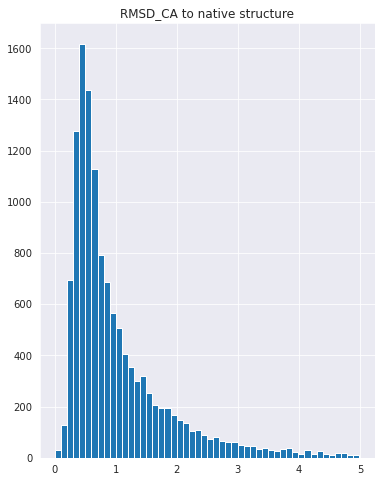

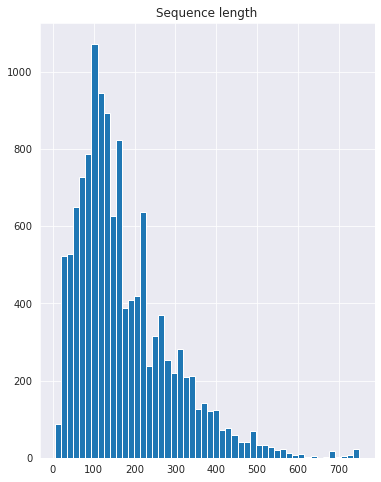

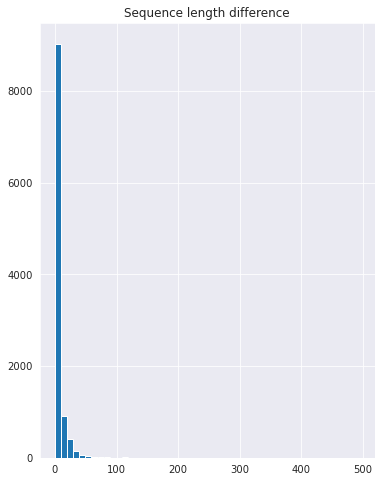

In [26]:
# Plot a histogram of the rmsd_ca values of the filtered dataframe
df_lowrmsd_nonastral.hist(column="rmsd_ca", bins=50)
plt.title("RMSD_CA to native structure")
# Make a second separate plot that doesn't overwrite the first. It should be a histogram of the sequence length
plt.figure()
df_lowrmsd_nonastral['sequence'].str.len().hist(bins=50)
plt.title("Sequence length");
# Plot a histogram of the sequence length difference
plt.figure()
df_lowrmsd_nonastral['len_difference'].hist(bins=50)
plt.title("Sequence length difference");

# Now we have a dataframe of proteins that should work without any further filtering
March 15, 10PM: 5964 proteins

In [27]:
df_filtered = df_lowrmsd_nonastral[df_lowrmsd_nonastral['sequence_matches_query']]
df_filtered

,protein_name,key,rmsd_ca,duration,protein_name_std,sequence,query_sequence,cif_exists,sequence_matches_query,sequence_is_subsequence,len_difference
0,10#1WAZ_1_A,RMSD_CA,0.636321,70.535076,1waz_A,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,TPVLVILLGVVGLSALTGYLDYVLLPALAIFIGLTIYAIQRKRQAD,True,True,True,0.0
1,10#2EEM_1_A,RMSD_CA,0.894565,34.606359,2eem_A,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,SCASRCKGHCRARRCGYYVSVLYRGRCYCKCLRC,True,True,True,0.0
3,10#2MNJ_1_A,RMSD_CA,0.352426,30.193380,2mnj_A,GPHMSVQIPVVEVDELPEGYDRS,GPHMSVQIPVVEVDELPEGYDRS,True,True,True,0.0
4,10#2MHD_1_A,RMSD_CA,0.737207,338.364634,2mhd_A,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,GDEDDKVEIPQLVGKWIVKEPVLQDDFVTCYTFNADKTYEVYTGSP...,True,True,True,0.0
6,10#2KW1_1_A,RMSD_CA,0.232314,120.852532,2kw1_A,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,EDRSKTTNTWVLHMDGENFRIVLEKDAMDVWCNGKKLETAGEFVDD...,True,True,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...
20292,2GGT_1_A,RMSD_CA,0.648192,1521.041160,2ggt_A,LLGGPFSLTTHTGERKTDKDYLGQWLLIYFGFTHCPDVCPEELEKM...,LLGGPFSLTTHTGERKTDKDYLGQWLLIYFGFTHCPDVCPEELEKM...,True,True,True,0.0
20298,2GH4_1_A,RMSD_CA,0.517604,11790.038120,2gh4_A,KSPLTYAEALANTIMNTYTVEELPPANRWHYHQGVFLCGVLRLWEA...,KSPLTYAEALANTIMNTYTVEELPPANRWHYHQGVFLCGVLRLWEA...,True,True,True,0.0
20301,2GHF_1_A,RMSD_CA,2.445763,280.117103,2ghf_A,MAHHHHHHNQQNKKVEGGYECKYCTFQTPDLNMFTFHVDSEHPNVV...,MAHHHHHHNQQNKKVEGGYECKYCTFQTPDLNMFTFHVDSEHPNVV...,True,True,True,0.0
20316,2GIM_1_A,RMSD_CA,0.213682,401.875954,2gim_A,METYTVKLGSDKGLLVFEPAKLTIKPGDTVEFLNNKVPPHNVVFDA...,METYTVKLGSDKGLLVFEPAKLTIKPGDTVEFLNNKVPPHNVVFDA...,True,True,True,0.0


In [ ]:
# TODO: See how hard it is to splice alignments by 1 or so. If it's not too hard, do it. If it is, just use the full alignment.

# Load and splice alignments according to how different the query and sequence are
def splice_alignment(protein_name, query_sequence, protein_sequence):
    """Returns the spliced alignment."""
    try:
        alignment_file = glob(f"/net/pulsar/home/koes/jok120/openfold/data/alignments/roda_flattened/alignments/{protein_name}/*.a3m")[0]
    except IndexError:
        return None
    # Read the alignment file
    with open(alignment_file, "r") as f:
        alignment = f.readlines()
    # Find the index of the query sequence
    query_index = alignment.index(f">{query_sequence}
                                  
    # Find the index of the protein sequence
    protein_index = alignment.index(f">{protein_sequence}
                                    
    # Splice the alignment
    spliced_alignment = alignment[query_index:protein_index+1]
    return spliced_alignment